# Quantum information and quantum computing - Problem set 11

### _Problem 1_ : Repetition quantum error correction code

In this notebook we will explore a simple type of error correction on quantum computers that takes advantage of repetitions. In this case, we are going to use $n=3$ physical qubits in order to represent the information contained in a single, logical qubit.

We do it by repeating the information contained in a single qubit on three qubits. Be careful that repeating does not mean "cloning". In fact, given a state

\begin{equation}
|\psi \rangle = \alpha |0\rangle + \beta |1 \rangle
\end{equation}

the repeated state is 

\begin{equation}
\alpha |000 \rangle + \beta |111 \rangle
\end{equation}

and not $|\psi \rangle \otimes |\psi \rangle \otimes |\psi \rangle$, which is in general prevented by the no-cloning theorem.

Therefore what we want to check is if the state is repeated in each of the three qubits.


In [1]:
# First, import all the useful methods

import numpy as np
import matplotlib.pyplot as plt   
import math

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import QasmSimulator

1) The first thing we want to create is a circuit that, using ancilla qubits , can spot errors by measuring the error syndromes. For $n=3$ we will need $m=2$ ancilla qubits, together with the classical registers.

In [2]:
# Create the circuits

cq = QuantumRegister(3,'code')
aq = QuantumRegister(2,'ancilla') 
sb = ClassicalRegister(2)

qc = QuantumCircuit(cq,aq,sb)

# Inegrate the CNOT to spot errors

qc.cx(cq[0],aq[0])
qc.cx(cq[1],aq[0])

qc.cx(cq[1],aq[1])
qc.cx(cq[2],aq[1])

qc.barrier()
# Measure

qc.measure(aq[0],sb[0])
qc.measure(aq[1],sb[1])

# Print the circuit
qc.draw('mpl', style={'name': 'iqx'})

/Users/clemensgiuliani/epfl/teaching/qc24/venv_qiskit/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /Users/clemensgiuliani/epfl/teaching/qc24/venv_qiskit/lib/python3.12/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


In this way, if the outcome of the measure is $00$, we know that no error occurred. If it's $01$ we know the first qubit was flipped, $10$ means the third qubit was fliped and, finally, $11$ means that the second qubit was flipped.

2) Now we implement the circuit on the `qasm_simulator` and see if it recognize the flips correctly.

In [3]:
## Call the backend

backend = QasmSimulator()
shots = 2048

As a first thing, we are going to see what appens if we do nothing to it

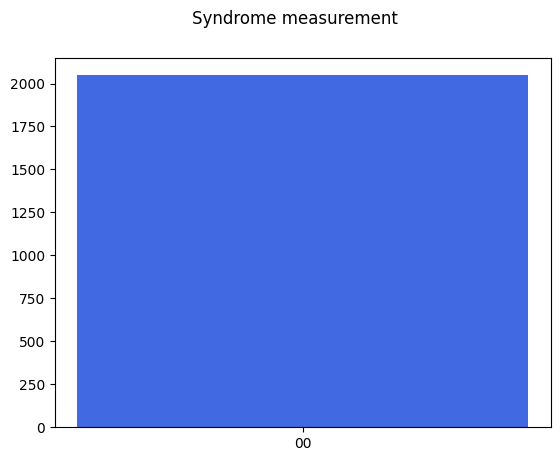

{'00': 2048}


In [4]:
results = backend.run(qc, shots=shots).result()
answer = results.get_counts()

plt.suptitle("Syndrome measurement")
plt.bar(answer.keys(), answer.values(), color='royalblue')
plt.show()

print(answer)

Now flip each of the qubits

In [5]:
# First qubit flipped

init = QuantumRegister(3,"code")
initc = QuantumCircuit(init, QuantumRegister(2), ClassicalRegister(2))
initc.x(init[0])



# Execute

results = backend.run(initc.compose(qc), shots=shots).result()
answer = results.get_counts()

plt.suptitle("Syndrome measurement for flip on first qubit")
plt.bar(answer.keys(), answer.values(), color='royalblue')
plt.show()

print(answer)


{'01': 2048}


In [6]:
# Second qubit flipped

init = QuantumRegister(3,"code")
initc = QuantumCircuit(init, QuantumRegister(2), ClassicalRegister(2))
initc.x(init[1])



# Execute

results = backend.run(initc.compose(qc), shots=shots).result()
answer = results.get_counts()

plt.suptitle("Syndrome measurement for flip on second qubit")
plt.bar(answer.keys(), answer.values(), color='royalblue')
plt.show()

print(answer)

{'11': 2048}


In [7]:
# Third qubit flipped

init = QuantumRegister(3,"code")
initc = QuantumCircuit(init, QuantumRegister(2), ClassicalRegister(2))
initc.x(init[2])



# Execute

results = backend.run(initc.compose(qc), shots=shots).result()
answer = results.get_counts()

plt.suptitle("Syndrome measurement for flip on third qubit")
plt.bar(answer.keys(), answer.values(), color='royalblue')
plt.show()

print(answer)

{'10': 2048}


So we have that our circuit recognize correctly the bit flips.

3) Now we are going to import a noise model from a real device in order to see how effective is the QECC we created to recognize errors

In [8]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer.noise import NoiseModel

simulator = GenericBackendV2(num_qubits=5)
noise_model = NoiseModel.from_backend(simulator)

In [9]:
# Initialize the circuit in |111>

init = QuantumRegister(3,"code")
initc = QuantumCircuit(init, QuantumRegister(2), ClassicalRegister(2))
initc.x(init[0])
initc.x(init[1])
initc.x(init[2])

# and execute the circuit with noise model


results = simulator.run(initc.compose(qc), backend=simulator, shots=shots,noise_model = noise_model).result()
answer = results.get_counts()

In [10]:
# Print the results

plt.suptitle("Syndrome measurement with hardware noise model")
plt.bar(answer.keys(), answer.values(), color='royalblue')
plt.show()

print(answer)

{'01': 29, '11': 3, '10': 28, '00': 1988}


As we can see, more than the $97\%$ of the shots didn't get any bit-flip errors, sometimes the first and the third qubits flipped. 

Remember that we are not detecting other types of errors, like the phase error.

4) Now we initialize the circuit with a generic initial state, as an example we create the state $\alpha|0\rangle+ \beta|1\rangle$ using a generic unitary on the first qubit and then we encode it in the repetition code 

In [11]:
init = QuantumRegister(3,"code")
initc = QuantumCircuit(init, QuantumRegister(2), ClassicalRegister(2))
initc.u(0.1,0.1,0.1,init[0])  ## Use some parameters \theta, \phi, \lambda of your choice
initc.cx(init[0],init[1])
initc.cx(init[1],init[2])
initc.barrier()

generic = initc.compose(qc)

generic.draw('mpl', style={'name': 'iqx'})

/Users/clemensgiuliani/epfl/teaching/qc24/venv_qiskit/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /Users/clemensgiuliani/epfl/teaching/qc24/venv_qiskit/lib/python3.12/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


In [12]:
# Execute
results = simulator.run(generic, shots=shots,noise_model = noise_model).result()
answer = results.get_counts()

In [13]:
# Print the results

plt.suptitle("Syndrome measurement with hardware noise model")
plt.bar(answer.keys(), answer.values(), color='royalblue')
plt.show()

print(answer)

{'01': 10, '11': 1, '10': 17, '00': 2020}


5) In general, gates are the source of errors during the time of our computation. Adding more gates means adding noise and therefore errors (remember the error rates indicated in the IBM Q Experience homepage). In particular, two-qubits gates are the gates with the higher error rate, this is the reason why we are going to implement an initialization circuits that ends with the preparation of |000> and contains some CNOTs in order to spot how the errors are more likely to appear in this case

In [14]:
# Long initialization circuit to recreate |000>

init = QuantumRegister(3,"code")
initc = QuantumCircuit(init, QuantumRegister(2), ClassicalRegister(2))
#1
initc.x(init[0])
initc.cx(init[0],init[1])
initc.cx(init[1],init[2])

initc.cx(init[2],init[1])
initc.cx(init[2],init[0])
initc.x(init[2])

#2
initc.x(init[0])
initc.cx(init[0],init[1])
initc.cx(init[1],init[2])

initc.cx(init[2],init[1])
initc.cx(init[2],init[0])
initc.x(init[2])

#3
initc.x(init[0])
initc.cx(init[0],init[1])
initc.cx(init[1],init[2])

initc.cx(init[2],init[1])
initc.cx(init[2],init[0])
initc.x(init[2])
initc.barrier()

# append it at the beginning of our QECC

final = initc.compose(qc)

final.draw('mpl', style={'name': 'iqx'})

/Users/clemensgiuliani/epfl/teaching/qc24/venv_qiskit/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /Users/clemensgiuliani/epfl/teaching/qc24/venv_qiskit/lib/python3.12/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


In [15]:
# Execute
results = simulator.run(final, shots=shots,noise_model = noise_model).result()
answer = results.get_counts()

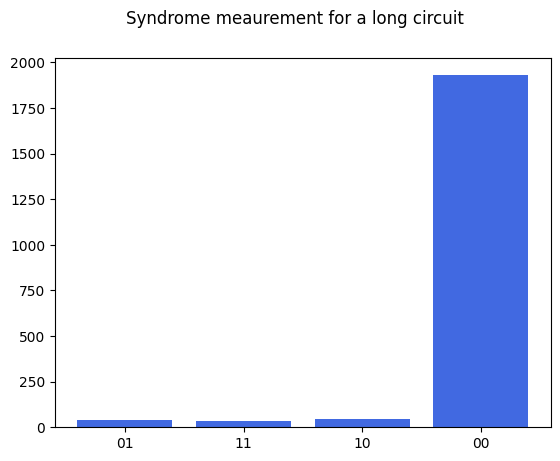

{'01': 40, '11': 35, '10': 44, '00': 1929}


In [16]:
# Print the results

plt.suptitle("Syndrome meaurement for a long circuit")
plt.bar(answer.keys(), answer.values(), color='royalblue')
plt.show()

print(answer)

We can see how the percentage of errors increased to more than the $5\%$ by adding gates to the circuit.